<h1 style="font-size:40px;">TripFare : Predicting Urban Taxi Fare with Machine Learning</h1>

In [194]:
import pandas as pd
import numpy as np
from datetime import datetime
from math import radians, sin, cos, sqrt, atan2
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer


import warnings
warnings.filterwarnings('ignore')

<h1 style="font-size:40px;">READ THE FILE</h1>

In [ ]:
data = pd.read_csv(r"C:\Users\Appu\Desktop\data science\python\taxi_fare.csv")
data.head()

In [12]:
data.rename(columns={
    'tpep_pickup_datetime': 'pickup_datetime',
    'tpep_dropoff_datetime': 'dropoff_datetime'    
}, inplace=True)

In [13]:
data.shape

(212345, 18)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212345 entries, 0 to 212344
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               212345 non-null  int64  
 1   pickup_datetime        212345 non-null  object 
 2   dropoff_datetime       212345 non-null  object 
 3   passenger_count        212345 non-null  int64  
 4   pickup_longitude       212345 non-null  float64
 5   pickup_latitude        212345 non-null  float64
 6   RatecodeID             212345 non-null  int64  
 7   store_and_fwd_flag     212345 non-null  object 
 8   dropoff_longitude      212345 non-null  float64
 9   dropoff_latitude       212345 non-null  float64
 10  payment_type           212345 non-null  int64  
 11  fare_amount            212345 non-null  float64
 12  extra                  212345 non-null  float64
 13  mta_tax                212345 non-null  float64
 14  tip_amount             212345 non-nu

In [15]:
data.describe()

,VendorID,passenger_count,pickup_longitude,pickup_latitude,RatecodeID,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,212345.000000,212345.000000,212345.000000,212345.000000,212345.000000,212345.000000,212345.000000,212345.000000,212345.000000,212345.000000,212345.000000,212345.000000,212345.000000,212345.000000,212345.000000
mean,1.708338,1.766493,-73.112122,40.279405,1.034152,-73.144178,40.295648,1.324943,12.665588,0.048077,0.497662,1.809357,0.329049,0.299637,15.649355
std,0.454529,1.469647,7.936633,4.370714,0.494699,7.794599,4.293031,0.478255,10.875584,0.148103,0.037436,2.507419,2.028199,0.014094,13.592129
min,1.000000,0.000000,-121.933327,0.000000,1.000000,-121.933327,0.000000,1.000000,-52.000000,-0.500000,-0.500000,-2.700000,0.000000,-0.300000,-52.800000
25%,1.000000,1.000000,-73.990891,40.740292,1.000000,-73.990570,40.740089,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.300000
50%,2.000000,1.000000,-73.979469,40.755989,1.000000,-73.978691,40.755508,1.000000,9.500000,0.000000,0.500000,1.350000,0.000000,0.300000,11.620000
75%,2.000000,2.000000,-73.963295,40.770283,1.000000,-73.964645,40.767475,2.000000,14.500000,0.000000,0.500000,2.360000,0.000000,0.300000,17.160000
max,2.000000,6.000000,0.000000,42.786934,99.000000,0.000000,42.786934,4.000000,819.500000,4.500000,0.500000,218.950000,661.080000,0.300000,832.800000


In [17]:
data.duplicated().sum()

0

In [18]:
data.rename(columns={
    'tpep_pickup_datetime': 'pickup_datetime',
    'tpep_dropoff_datetime': 'dropoff_datetime'    
}, inplace=True)

In [21]:
# Convert pickup_datetime and dropoff_datetime to datetime object
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'], utc=True)
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'], utc=True)

In [28]:
# Convert UTC to EDT (Eastern Daylight Time)
data['pickup_datetime'] = data['pickup_datetime'].dt.tz_convert('US/Eastern')
data['dropoff_datetime'] = data['dropoff_datetime'].dt.tz_convert('US/Eastern')

In [30]:
#Adding new column trip distance
def haversine(lon1, lat1, lon2, lat2):
    R = 6371  # Radius of Earth in kilometers
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

data['trip_distance'] = data.apply(
    lambda row: haversine(row['pickup_longitude'], row['pickup_latitude'],
                          row['dropoff_longitude'], row['dropoff_latitude']), axis=1)

In [31]:
# Create 'pickup_day' column as 'Weekday' or 'Weekend'
data['pickup_day'] = data['pickup_datetime'].dt.dayofweek  # 0=Monday, 6=Sunday
data['pickup_day'] = data['pickup_day'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

In [32]:
#AM PM indicator

data['am_pm'] = data['pickup_datetime'].dt.strftime('%p')  # AM or PM

In [33]:
#is night(Binary flag for late-night/early-morning trips)

data['is_night'] = data['pickup_datetime'].dt.hour.apply(lambda x: 1 if (x >= 22 or x < 5) else 0)

In [34]:
#rush hour

data['is_rush_hour'] = data['pickup_datetime'].dt.hour.apply(
    lambda x: 1 if (7 <= x <= 9 or 16 <= x <= 19) else 0
)

In [35]:

data['trip_duration'] = (data['dropoff_datetime'] - data['pickup_datetime']).dt.total_seconds() / 60

In [36]:
data = data.drop(['RatecodeID', 'store_and_fwd_flag', 'improvement_surcharge'], axis=1)

In [37]:
data = data.drop(["VendorID"], axis=1)

In [38]:
data = data.drop(['pickup_datetime', 'dropoff_datetime', 'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], axis=1)

In [41]:
(data['pickup_day']=="weekend").sum()

0

In [42]:
data = data.drop(["pickup_day"], axis=1)

In [43]:
data['trip_distance'] = data['trip_distance'].round(1)

In [51]:
data['trip_duration'] = data['trip_duration'].round(1)

In [55]:

data['trip_distance'] = data['trip_distance'].mask(data['trip_distance'] > 50, np.nan)
data['total_amount'] = data['total_amount'].mask(data['total_amount'] > 300, np.nan)
data['trip_duration'] = data['trip_duration'].mask(data['trip_duration'] > 180, np.nan)
data = data.dropna(subset=['trip_distance','total_amount','trip_duration'])


In [58]:
print(data.isnull().sum())

passenger_count    0
payment_type       0
fare_amount        0
extra              0
mta_tax            0
tip_amount         0
tolls_amount       0
total_amount       0
trip_distance      0
am_pm              0
is_night           0
is_rush_hour       0
trip_duration      0
dtype: int64


In [60]:
negatives = (data.select_dtypes(include=['number']) < 0).any(axis=1)
data[negatives]

,passenger_count,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount,trip_distance,am_pm,is_night,is_rush_hour,trip_duration
407,1,3,-5.5,0.0,-0.5,0.00,0.0,-6.30,0.7,AM,1,0,5.3
1119,1,3,-2.5,0.0,-0.5,0.00,0.0,-3.30,20.6,AM,1,0,91.0
2231,1,3,-7.0,0.0,-0.5,-2.34,0.0,-10.14,1.4,AM,1,0,8.0
4138,1,3,-2.5,0.0,-0.5,0.00,0.0,-3.30,0.2,AM,1,0,0.4
7141,5,4,-2.5,0.0,-0.5,-0.66,0.0,-3.96,0.0,AM,1,0,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
203293,2,4,-2.5,0.0,-0.5,0.00,0.0,-3.30,0.0,AM,0,0,0.8
204041,1,2,-3.0,0.0,-0.5,0.00,0.0,-3.80,0.1,AM,0,0,1.0
208970,1,4,-5.5,0.0,-0.5,0.00,0.0,-6.30,0.5,AM,0,1,6.3
209202,1,4,-4.5,0.0,-0.5,0.00,0.0,-5.30,0.6,AM,0,1,4.0


In [62]:
data = data[~negatives]

In [64]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [66]:
data.dropna(inplace=True)

In [68]:
(data['trip_duration']==0).sum()

117

In [70]:
data = data[data['trip_duration'] != 0]

In [72]:
data = data[data['trip_distance'] != 0]

In [74]:
data = data[data['total_amount'] != 0]

In [76]:
data = data[data['fare_amount'] != 0]

In [78]:
data = data[data['passenger_count'] != 0]

<h1 style="font-size:40px;">OUTLIER DETECTION</h1>

In [80]:
numerical_cols = data.select_dtypes(exclude='object').columns
numerical_cols

Index(['passenger_count', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'total_amount', 'trip_distance',
       'is_night', 'is_rush_hour', 'trip_duration'],
      dtype='object')

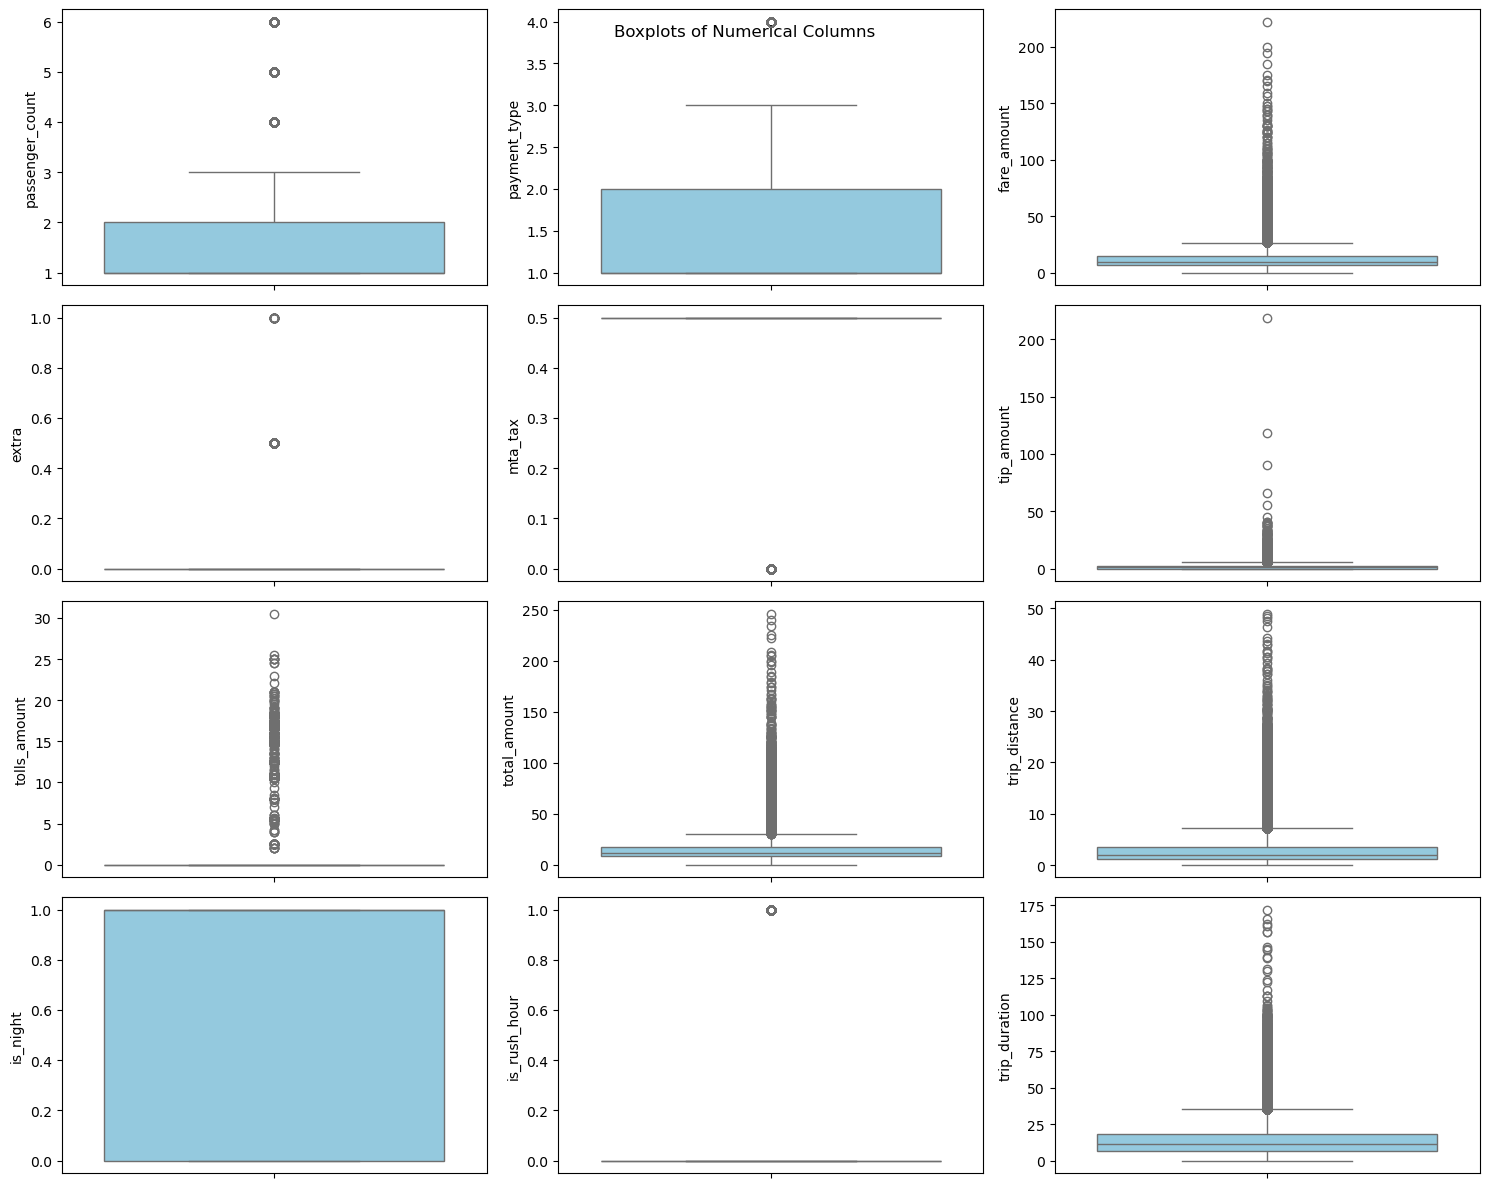

In [82]:
plt.figure(figsize=(15, 30))
plt.suptitle('Boxplots of Numerical Columns')
for i in range(0, len(numerical_cols)):
    plt.subplot(10,3, i+1)
    sns.boxplot(y=data[numerical_cols[i]],color='skyblue',)
    plt.tight_layout()

In [83]:
def remove_all_outliers(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

# Usage
data = remove_all_outliers(data, numerical_cols)

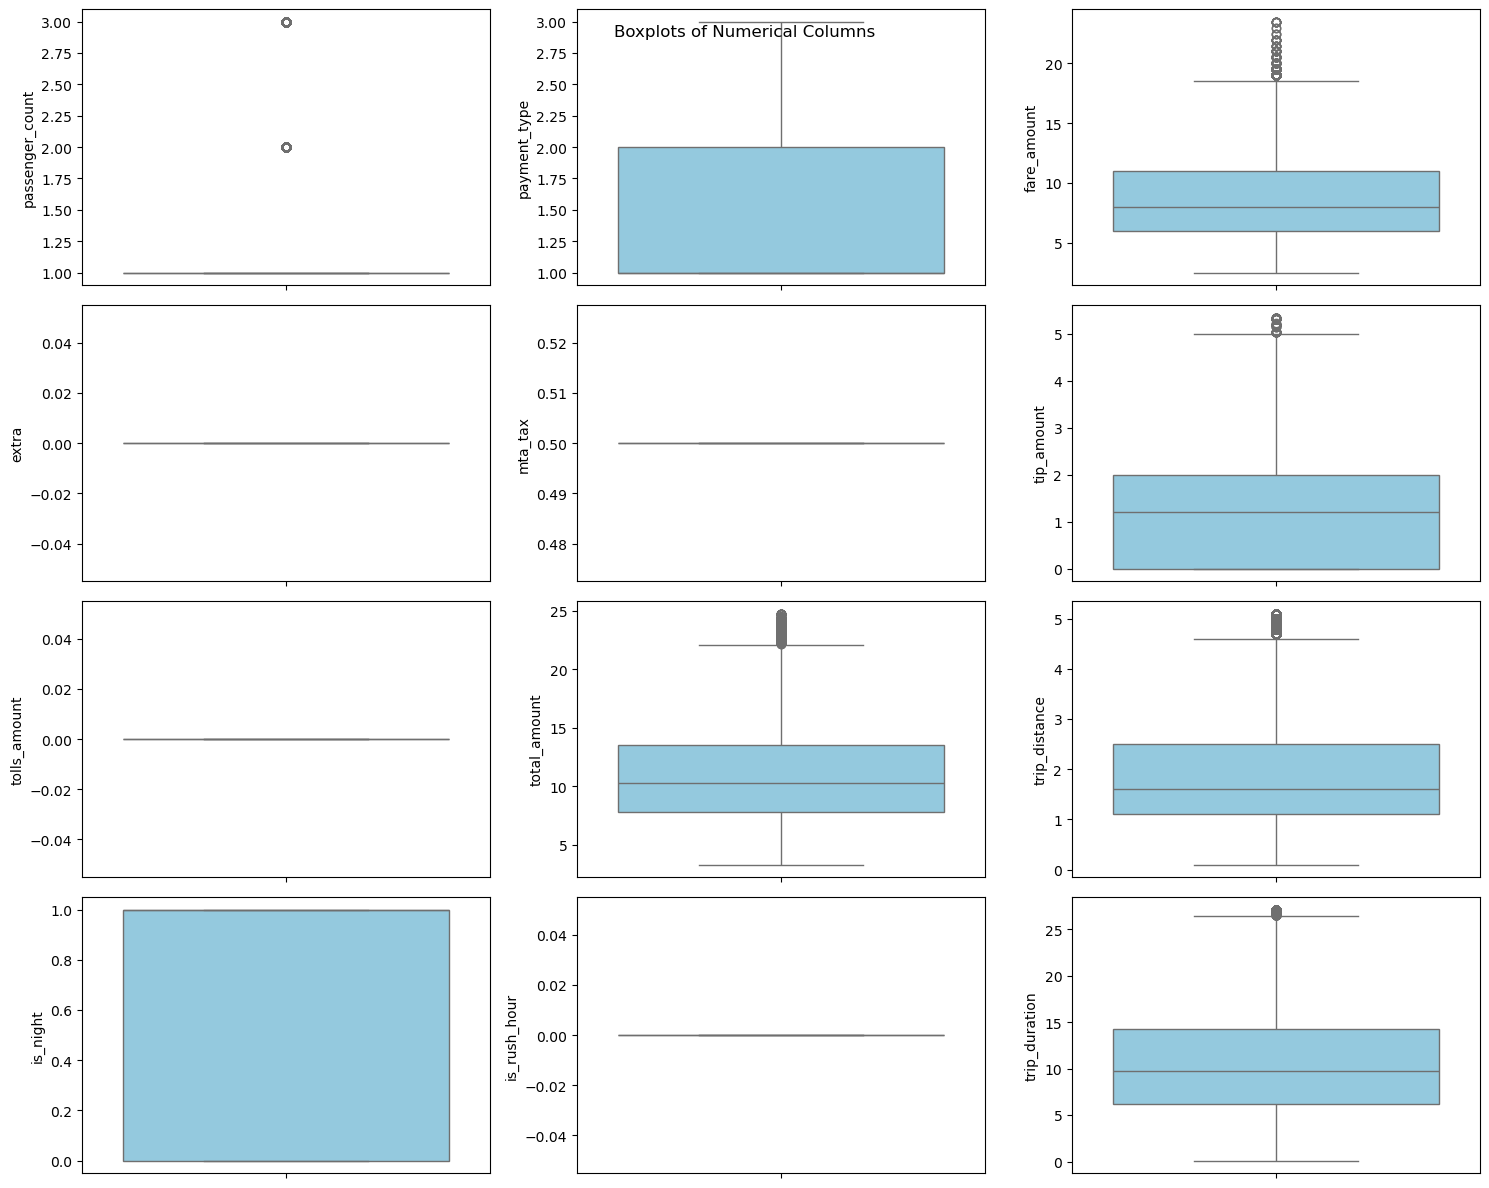

In [84]:
plt.figure(figsize=(15, 30))
plt.suptitle('Boxplots of Numerical Columns')
for i in range(0, len(numerical_cols)):
    plt.subplot(10,3, i+1)
    sns.boxplot(y=data[numerical_cols[i]],color='skyblue',)
    plt.tight_layout()

<h1 style="font-size:40px;">ENCODING</h1>

In [85]:
data['am_pm'] = data['am_pm'].map({'AM': 0, 'PM': 1})

In [86]:
data = pd.get_dummies(data, columns=['payment_type'], drop_first=True)

In [87]:
data.head()

,passenger_count,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount,trip_distance,am_pm,is_night,is_rush_hour,trip_duration,payment_type_2,payment_type_3
173,1,6.0,0.0,0.5,1.36,0.0,8.16,1.3,0,1,0,5.3,False,False
174,2,13.0,0.0,0.5,1.50,0.0,15.30,3.8,0,1,0,15.7,False,False
175,2,8.5,0.0,0.5,1.86,0.0,11.16,3.3,0,1,0,6.5,False,False
179,1,6.5,0.0,0.5,0.00,0.0,7.30,1.7,0,1,0,6.4,True,False
180,3,9.0,0.0,0.5,2.00,0.0,11.80,3.8,0,1,0,8.2,False,False


<h1 style="font-size:40px;">SKEWNESS</h1>

In [90]:
skewness=data.skew()

In [91]:
skewness

passenger_count     2.283728
fare_amount         0.660773
extra               0.000000
mta_tax             0.000000
tip_amount          0.475822
tolls_amount        0.000000
total_amount        0.673818
trip_distance       0.907454
am_pm              76.316171
is_night           -0.703168
is_rush_hour        0.000000
trip_duration       0.652560
payment_type_2      0.809859
payment_type_3     29.830723
dtype: float64

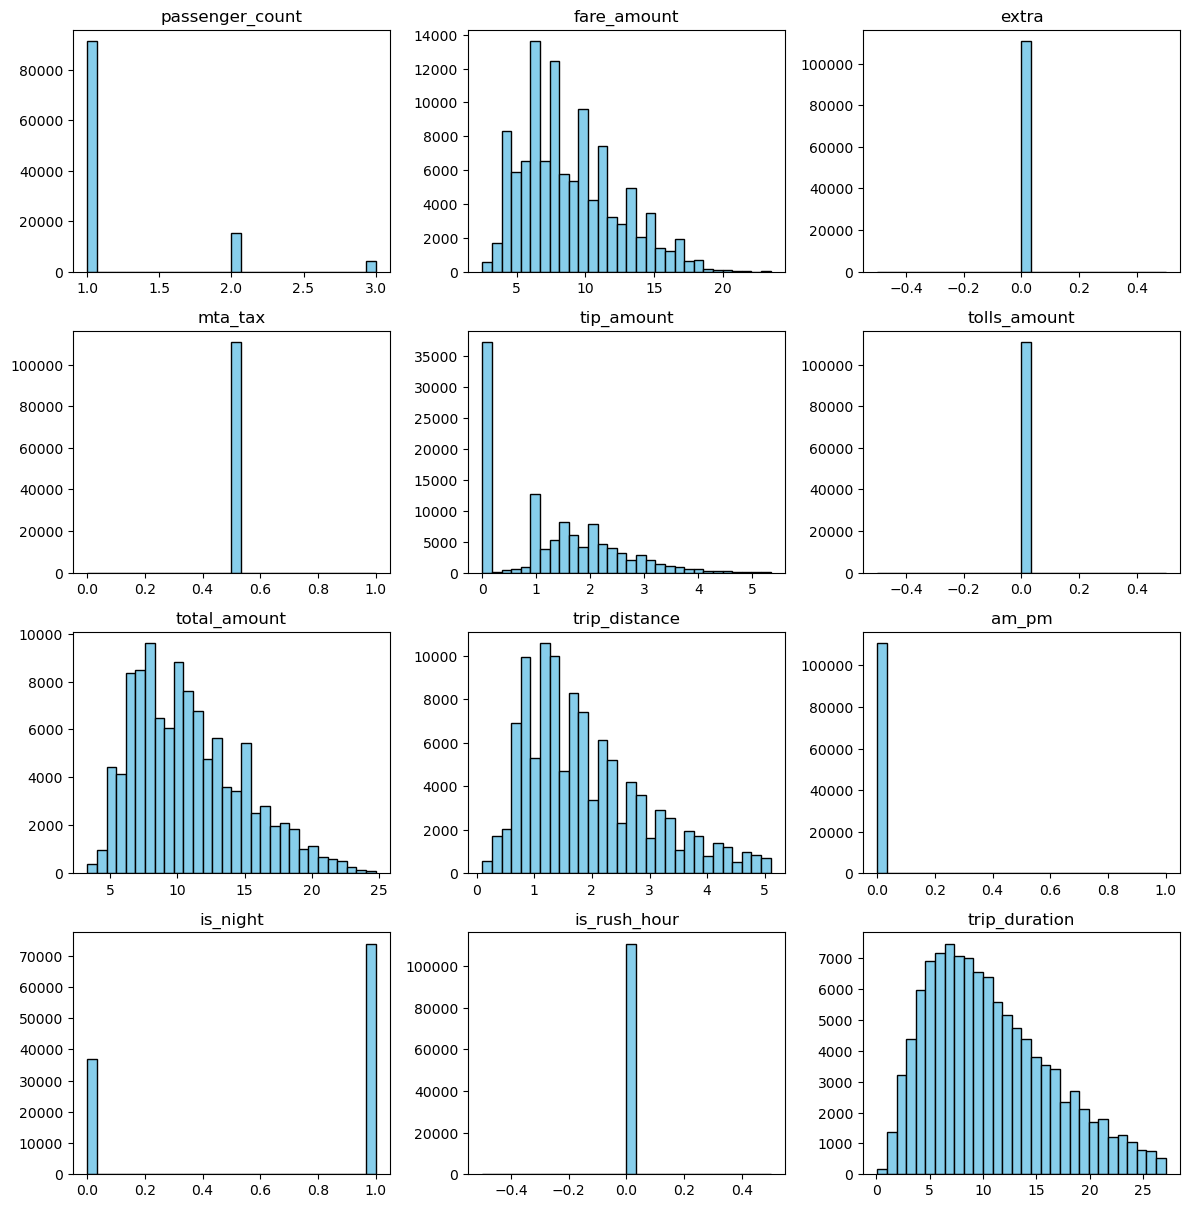

In [96]:
# Select numerical columns with high skewness (absolute skewness > 0.5)
skewed_cols = skewness.index
# Filter only numeric and non-boolean columns
numeric_cols = data[skewed_cols].select_dtypes(include=[np.number])
non_bool_cols = numeric_cols.loc[:, numeric_cols.dtypes != 'bool'].columns

# Plot histograms before transformation
plt.figure(figsize=(12, 30))
for i, col in enumerate(non_bool_cols, 1):
    plt.subplot(10, 3, i)
    plt.hist(data[col].dropna(), bins=30, color='skyblue', edgecolor='black')  # dropna to avoid NaN issues
    plt.title(f"{col}")
plt.tight_layout()
plt.show()

In [98]:
data['fare_amount'] = np.log1p(data['fare_amount'])
data['trip_distance'] = np.log1p(data['trip_distance'])
data['tip_amount'] = np.log1p(data['tip_amount'])
data['trip_duration'] = np.log1p(data['trip_duration'])
data['total_amount'] = np.log1p(data['total_amount'])

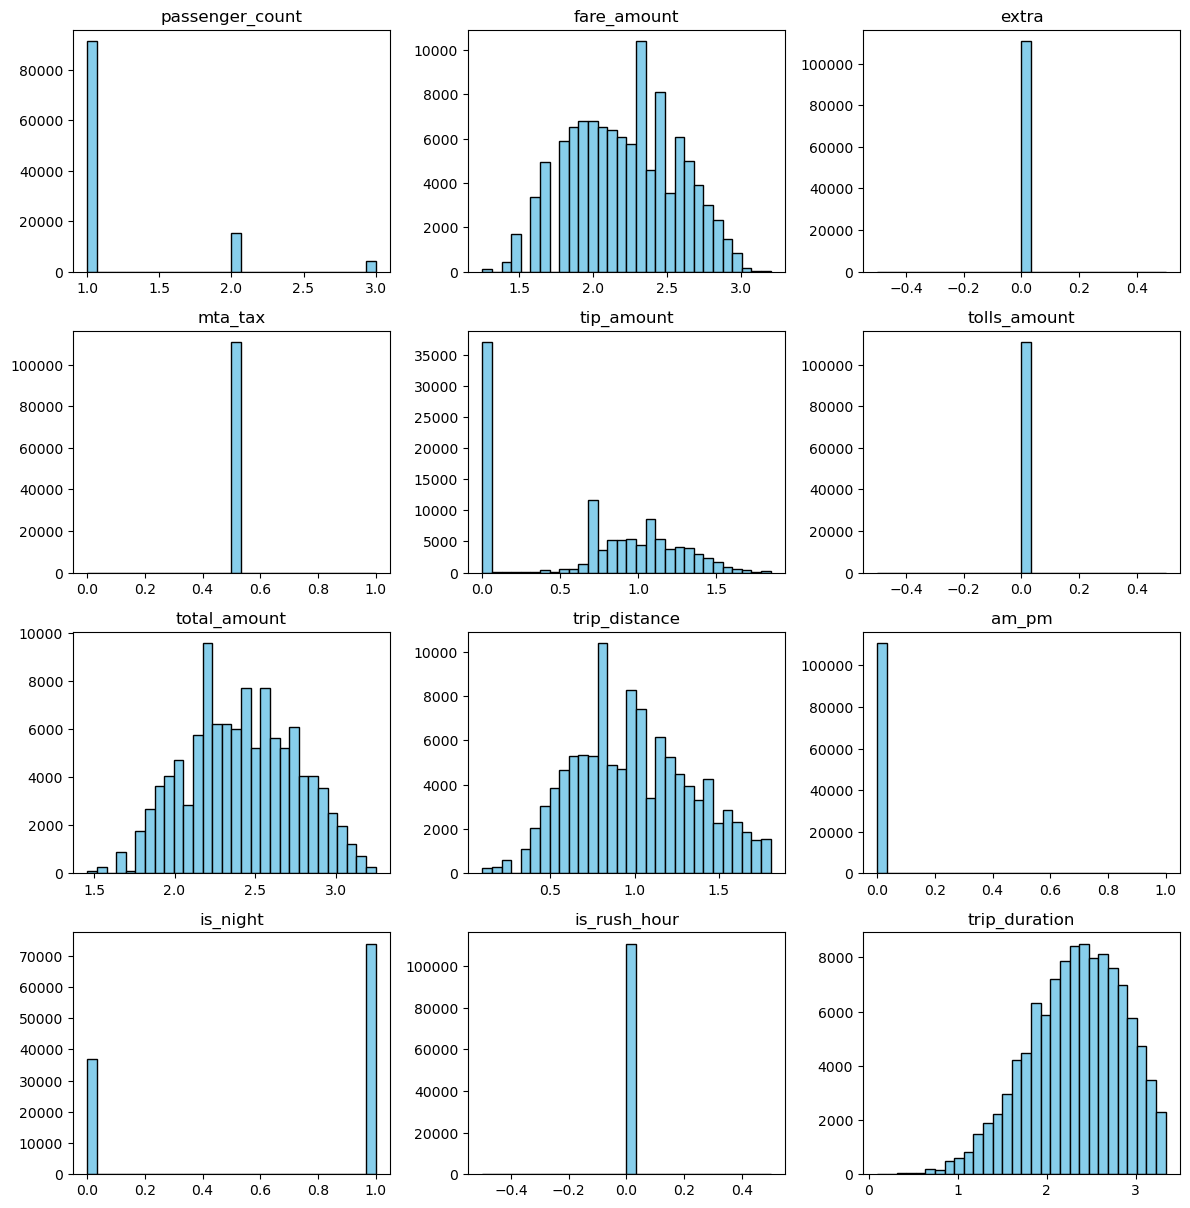

In [102]:
#after transformation
plt.figure(figsize=(12, 30))
for i, col in enumerate(non_bool_cols, 1):
    plt.subplot(10, 3, i)
    plt.hist(data[col].dropna(), bins=30, color='skyblue', edgecolor='black')  # dropna to avoid NaN issues
    plt.title(f"{col}")
plt.tight_layout()
plt.show()

In [104]:
skewness=data.skew()
skewness

passenger_count     2.283728
fare_amount        -0.010773
extra               0.000000
mta_tax             0.000000
tip_amount         -0.174085
tolls_amount        0.000000
total_amount       -0.010146
trip_distance       0.209400
am_pm              76.316171
is_night           -0.703168
is_rush_hour        0.000000
trip_duration      -0.399653
payment_type_2      0.809859
payment_type_3     29.830723
dtype: float64

In [106]:
data.head()

,passenger_count,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount,trip_distance,am_pm,is_night,is_rush_hour,trip_duration,payment_type_2,payment_type_3
173,1,1.945910,0.0,0.5,0.858662,0.0,2.214846,0.832909,0,1,0,1.840550,False,False
174,2,2.639057,0.0,0.5,0.916291,0.0,2.791165,1.568616,0,1,0,2.815409,False,False
175,2,2.251292,0.0,0.5,1.050822,0.0,2.498152,1.458615,0,1,0,2.014903,False,False
179,1,2.014903,0.0,0.5,0.000000,0.0,2.116256,0.993252,0,1,0,2.001480,True,False
180,3,2.302585,0.0,0.5,1.098612,0.0,2.549445,1.568616,0,1,0,2.219203,False,False


<Axes: >

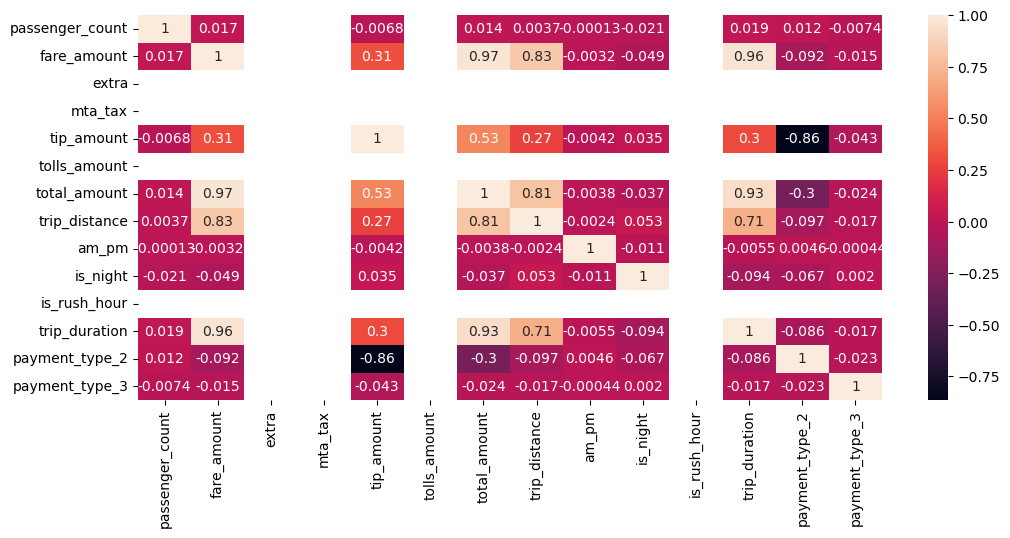

In [108]:
corr_matrix = data.corr()
plt.subplots(figsize=(12,5))
sns.heatmap(corr_matrix,annot=True)

In [110]:
data.dtypes

passenger_count      int64
fare_amount        float64
extra              float64
mta_tax            float64
tip_amount         float64
tolls_amount       float64
total_amount       float64
trip_distance      float64
am_pm                int64
is_night             int64
is_rush_hour         int64
trip_duration      float64
payment_type_2        bool
payment_type_3        bool
dtype: object

In [112]:
data['payment_type_2'] = data['payment_type_2'].astype(int)
data['payment_type_3'] = data['payment_type_3'].astype(int)

In [114]:
data['is_rush_hour'].value_counts()

is_rush_hour
0    110713
Name: count, dtype: int64

In [116]:
data = data.drop('is_rush_hour', axis=1)

<h1 style="font-size:40px;">FEATURE SELECTION</h1>

In [118]:
categorical_cols = ['payment_type_2', 'am_pm', 'is_night','payment_type_3']
X_cat = data[categorical_cols]
# Bin target (e.g., total_amount) for classification-like testing
binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
y_binned = binner.fit_transform(data[['total_amount']]).ravel()

# Apply Chi-Square test
chi_scores, p_values = chi2(X_cat, y_binned)
chi2_df = pd.DataFrame({'Feature': categorical_cols, 'Chi2 Score': chi_scores, 'p-value': p_values})
chi2_df.sort_values('Chi2 Score', ascending=False)

,Feature,Chi2 Score,p-value
0,payment_type_2,5316.151718,0.000000e+00
2,is_night,64.340030,3.543935e-13
3,payment_type_3,46.076256,2.374482e-09
1,am_pm,8.377583,7.868595e-02


Keep: payment_type_2, is_night, payment_type_3


In [121]:
data = data.reset_index(drop=True)

In [123]:
data.to_csv("data_cleaned.csv",index=False)

In [125]:
!pip install xgboost

In [126]:
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [129]:
# Select features and target
val = data.drop(columns=['fare_amount','total_amount'], errors='ignore')
tar= data['total_amount']

# Convert categorical features if necessary
features = pd.get_dummies(val, drop_first=True)

# Train model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(val, tar)

# Get importance
importances = rf.feature_importances_
feature_names = val.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df.sort_values('Importance', ascending=False)

,Feature,Importance
8,trip_duration,0.844798
3,tip_amount,0.115195
5,trip_distance,0.037866
7,is_night,0.000943
0,passenger_count,0.000786
9,payment_type_2,0.000345
10,payment_type_3,0.000058
6,am_pm,0.000009
1,extra,0.000000
2,mta_tax,0.000000


In [130]:
selected_features = [
    'trip_duration',
    'trip_distance',
    'is_night',
    'payment_type_2',
    'payment_type_3',
    'tip_amount',
    'total_amount',
    
    
]
data_selected = data[selected_features]

In [131]:
data.head()

,passenger_count,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount,trip_distance,am_pm,is_night,trip_duration,payment_type_2,payment_type_3
0,1,1.945910,0.0,0.5,0.858662,0.0,2.214846,0.832909,0,1,1.840550,0,0
1,2,2.639057,0.0,0.5,0.916291,0.0,2.791165,1.568616,0,1,2.815409,0,0
2,2,2.251292,0.0,0.5,1.050822,0.0,2.498152,1.458615,0,1,2.014903,0,0
3,1,2.014903,0.0,0.5,0.000000,0.0,2.116256,0.993252,0,1,2.001480,1,0
4,3,2.302585,0.0,0.5,1.098612,0.0,2.549445,1.568616,0,1,2.219203,0,0


<h1 style="font-size:40px;">REGRESSION MODEL</h1>

In [133]:
X = data_selected.drop('total_amount',axis=1)
y = data_selected['total_amount']

In [134]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [135]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Lasso Regression": Lasso(alpha=0.1),
    "Ridge regression" : Ridge(alpha=1.0),
    "KNeighborsRegressor": KNeighborsRegressor(n_neighbors=5),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBoost Regressor": XGBRegressor()
}
# Train and evaluate models
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Predict on test data

    # Compute evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2 Score": r2
    }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
results_df

,MAE,MSE,RMSE,R2 Score
Linear Regression,0.039929,0.003226,0.056794,0.971863
Decision Tree Regressor,0.022551,0.002383,0.048815,0.979213
Lasso Regression,0.185102,0.050727,0.225227,0.557490
Ridge regression,0.039929,0.003226,0.056794,0.971862
KNeighborsRegressor,0.023112,0.001753,0.041867,0.984710
Random Forest Regressor,0.020221,0.001673,0.040899,0.985408
XGBoost Regressor,0.024212,0.001609,0.040110,0.985966


In [143]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

# Define the model
xgb = XGBRegressor(n_estimators=100, random_state=42)

# Define K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform Cross-Validation
cv_scores = cross_val_score(xgb, X, y, cv=kf, scoring='r2')

# Print all 5 scores
print(f"All 5-Fold Scores: {cv_scores}")
print()
# Compare Mean and Standard Deviation
print(f"Mean R2 Score: {np.mean(cv_scores):.4f}")

All 5-Fold Scores: [0.9854822  0.98701751 0.98621759 0.98649526 0.98511365]

Mean R2 Score: 0.9861


<h1 style="font-size:40px;">HYPERTUNING</h1>

In [145]:
import xgboost as xgb
from xgboost import XGBRegressor

In [148]:
model = xgb.XGBRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1],
}

grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           scoring='r2',
                           cv=5,
                           n_jobs=-1,
                           verbose=2)

search = grid_search 
search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7, 10],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.7, 0.8, 1]},
             scoring='r2', verbose=2)

In [150]:
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

print("Best Parameters:", search.best_params_)
print("R2 Score:", r2_score(y_test, y_pred))

Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}
R2 Score: 0.9864508724679674


In [168]:
import pickle
feature_order = ['trip_duration', 'tip_amount', 'trip_distance', 'is_night', 'payment_type_2', 'payment_type_3']
with open("tuned_xgboost_model.pkl", "wb") as f:
    pickle.dump((best_model, feature_order), f)



In [172]:
import pickle

with open("tuned_xgboost_model.pkl", "rb") as f:
    loaded_model, feature_order = pickle.load(f)

In [174]:
predictions = loaded_model.predict(X_test)

In [192]:
# Get inputs
trip_duration = float(input("Trip duration (min): "))
tip_amount = float(input("Tip amount: "))
trip_distance = float(input("Trip distance (km): "))
is_night = int(input("Is it night? (1 = Yes, 0 = No): "))
payment_type = int(input("Payment type (1=Credit, 2=Cash, 3=No Charge): "))

# Transform
log_trip_duration = np.log1p(trip_duration)
log_tip_amount = np.log1p(tip_amount)
log_trip_distance = np.log1p(trip_distance)

payment_type_2 = 1 if payment_type == 2 else 0
payment_type_3 = 1 if payment_type == 3 else 0

input_data = pd.DataFrame([{
    'trip_duration': log_trip_duration,
    'trip_distance': log_trip_distance,
    'is_night': is_night,    
    'payment_type_2': payment_type_2,
    'payment_type_3': payment_type_3,
    'tip_amount': log_tip_amount,
    
}])

# ✅ Ensure correct feature order
feature_order = ['trip_duration','trip_distance','is_night', 'payment_type_2', 'payment_type_3','tip_amount']
input_data = input_data[feature_order]

# Predict and inverse transform
log_pred = loaded_model.predict(input_data)
predicted_total = np.expm1(log_pred[0])

print(f"\n✅ Predicted Total Amount: ${predicted_total:.2f}")

Trip duration (min):  1.8
Tip amount:  0.8
Trip distance (km):  0.8
Is it night? (1 = Yes, 0 = No):  1
Payment type (1=Credit, 2=Cash, 3=No Charge):  1



✅ Predicted Total Amount: $5.16


In [190]:
data_selected.head()

,trip_duration,trip_distance,is_night,payment_type_2,payment_type_3,tip_amount,total_amount
0,1.840550,0.832909,1,0,0,0.858662,2.214846
1,2.815409,1.568616,1,0,0,0.916291,2.791165
2,2.014903,1.458615,1,0,0,1.050822,2.498152
3,2.001480,0.993252,1,1,0,0.000000,2.116256
4,2.219203,1.568616,1,0,0,1.098612,2.549445
